In [1]:
import __init__

from src.utilities import train_test_validation_splits, \
                            prepare_train_test_val_seqs_by_batches, \
                            tensor2dataloader, load_full_meltome_FLIP_db, \
                            seek_UniprotID_association_Meltome_prots,\
                            download_UniprotID_Alphafold_Structures,\
                            get_guided_encoder_output,\
                            ESM2_IF_repr
                            
import pandas as pd
import numpy as np
    
import ipdb
path_meltome = '../datasets/FLIP/splits/meltome/splits/mixed_split.csv'
complete_meltome_db = '../datasets/FLIP/splits/meltome/full_dataset_sequences.fasta'

full_meltome_db = load_full_meltome_FLIP_db(complete_meltome_db)

splits_meltome = pd.read_csv(path_meltome, sep=',')

#import ipdb; ipdb.set_trace()

splits_meltome = seek_UniprotID_association_Meltome_prots(splits_meltome, full_meltome_db)
split_meltome = splits_meltome[splits_meltome['sequence'].str.len()>= 50]
train, val, test = train_test_validation_splits(splits_meltome)

print("Done")

Done


In [2]:
def outlier_seeker(df_t, root_path, id, std=5):

    import ipdb; ipdb.set_trace()

    for org  in train.organism.unique():
        df_t = train[train.organism.str.contains(org)].sort_values(by='target',ascending=False)
        org_tm_threshold = df_t[df_t.organism.str.contains(org)].tm_organism.unique().item() + std
        df_t.target = df_t.target.astype('float')
        outliers = df_t.query('target > @org_tm_threshold')[['full_name', 'protein_id','target','tm_organism']].iloc[0:50]#[['full_name', 'target','tm_organism']]
        outliers.to_csv('outliers/'+org+'_'+id+'.csv', index=False, sep="\t")

#outlier_seeker(train, 'outliers/','train')

In [3]:

from tqdm.auto import tqdm
import torch
from src.ESM2embeddings import ESM2embeddings
from src.ESM2_IF1_embeddings import ESM2_IF1_embeddings
from src.utilities import train_test_validation_splits, prepare_train_test_val_seqs_by_batches, tensor2dataloader,read_and_plot_loss_curves, cleanup_by_organism_and_correspondence_idx
from src.NeuralArchitectures import regressionHead
from src.Trainer_seq_struct import Trainer_Seq_Struct
from src.Trainer_seq_struct2 import Trainer_Seq_Struct2

from src.AdaptiveDataset import AdaptiveDataset

structuredir = '../datasets/Structures/'
meltome_struct_dir_labels = '../datasets/'
organism = 'coli'
keyword = 'lysate'

import os 
if not os.listdir(structuredir) and not os.path.isfile(meltome_struct_dir_labels+'Meltome_Splits_FLIPS_train.txt')\
                                and not os.path.isfile(meltome_struct_dir_labels+'Meltome_Splits_FLIPS_test.txt')\
                                and not os.path.isfile(meltome_struct_dir_labels+'Meltome_Splits_FLIPS_val.txt'): 
    
    print("Finding structures to proteins via Alphafold/PDB dbs..........") 
    
    download_UniprotID_Alphafold_Structures(train, structuredir, meltome_struct_dir_labels, 'Meltome_Splits_FLIPS_train')
    download_UniprotID_Alphafold_Structures(test, structuredir, meltome_struct_dir_labels, 'Meltome_Splits_FLIPS_test')
    download_UniprotID_Alphafold_Structures(val, structuredir, meltome_struct_dir_labels, 'Meltome_Splits_FLIPS_val')



Structinfo_Meltome_Splits_train = pd.read_csv( meltome_struct_dir_labels+'Meltome_Splits_FLIPS_train.txt', sep='\t').set_index(train.index)
Structinfo_Meltome_Splits_test = pd.read_csv( meltome_struct_dir_labels+'Meltome_Splits_FLIPS_test.txt', sep='\t').set_index(test.index)
Structinfo_Meltome_Splits_val = pd.read_csv( meltome_struct_dir_labels+'Meltome_Splits_FLIPS_val.txt', sep='\t').set_index(val.index)


#import ipdb; ipdb.set_trace()

train = pd.concat([train, Structinfo_Meltome_Splits_train], axis=1).query('Source=="alphafold"')
test = pd.concat([test, Structinfo_Meltome_Splits_test], axis=1).query('Source=="alphafold"')
val = pd.concat([val, Structinfo_Meltome_Splits_val], axis=1).query('Source=="alphafold"')


idxdf_idxfile_train, _ = cleanup_by_organism_and_correspondence_idx(train, ['coli_lysate','Caenorhabditis_elegans_lysate'], keyword)
idxdf_idxfile_test, _ = cleanup_by_organism_and_correspondence_idx(test, organism, keyword)
idxdf_idxfile_val, _ = cleanup_by_organism_and_correspondence_idx(val, ['coli_lysate','Caenorhabditis_elegans_lysate'], keyword)
    

In [4]:
import torch
import src.IF_PiFold_embeddings  as PiFoldconf 
#from src.IF_PiFold_embeddings import PiFold_setup


args = PiFoldconf.get_parser()
exp = PiFoldconf.PiFold_setup(args)
svpath = '../ref_models/PiFold/results/'
exp.method.load_state_dict(torch.load(svpath+'checkpoint.pth'))

import torch, os, gc
import torch_geometric
import torch_sparse
from torch_geometric.nn import MessagePassing
import warnings
warnings.filterwarnings('ignore')

pt_batch_size = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ESM2 = ESM2embeddings(type_embedding = "facebook/esm2_t33_650M_UR50D", device = device, type_tool='FacebookESM2')

dir_pre_generated_embeddings = '../prepro_embeddings/ESM2_single_embeddings_nobatches/'

path_train= dir_pre_generated_embeddings+'train_set_embeddings_ESM2_with_StructAssociation.pth'
path_test= dir_pre_generated_embeddings+'test_set_embeddings_ESM2_with_StructAssociation.pth'
path_val= dir_pre_generated_embeddings+'val_set_embeddings_ESM2_with_StructAssociation.pth'

path_IFtrain= dir_pre_generated_embeddings+'train_set_IFPiFoldembeddings_ESM2_StructAssociation.pth'
path_IFtest= dir_pre_generated_embeddings+'test_set_IFPiFoldembeddings_ESM2_StructAssociation.pth'
path_IFval= dir_pre_generated_embeddings+'val_set_IFPiFoldembeddings_ESM2_StructAssociation.pth'

Use GPU: cuda:0



device: 	cuda	
display_step: 	10	
res_dir: 	results	
ex_name: 	ProDesign	
use_gpu: 	True	
gpu: 	0	
seed: 	111	
data_name: 	CATH	
data_root: 	data/	
batch_size: 	8	
num_workers: 	8	
method: 	ProDesign	
config_file: 	None	
hidden_dim: 	128	
node_features: 	128	
edge_features: 	128	
k_neighbors: 	30	
dropout: 	0.1	
num_encoder_layers: 	10	
epoch: 	100	
log_step: 	1	
lr: 	0.001	
patience: 	100	
updating_edges: 	4	
node_dist: 	1	
node_angle: 	1	
node_direct: 	1	
edge_dist: 	1	
edge_angle: 	1	
edge_direct: 	1	
virtual_num: 	3	


Creating Embeddings...


  0%|          | 0/22001 [00:00<?, ?it/s]

  0%|          | 0/3076 [00:00<?, ?it/s]

  0%|          | 0/2438 [00:00<?, ?it/s]

  0%|          | 0/22001 [00:00<?, ?it/s]

  0%|          | 0/3076 [00:00<?, ?it/s]

  0%|          | 0/2438 [00:00<?, ?it/s]

starting UMAP mapping ....


ESM2 EMBEDDINGS UMAP PLOTS:


(' ESM2 categories on training data: \n'
 " ['Arabidopsis_thaliana_seedling_lysate', 'Bacillus_subtilis_168_lysate_R1', "
 "'Caenorhabditis_elegans_lysate', 'Danio_rerio_Zenodo_lysate', "
 "'Drosophila_melanogaster_SII_lysate', 'Escherichia_coli_cells', "
 "'Escherichia_coli_lysate', 'Geobacillus_stearothermophilus_NCA26_lysate', "
 "'HAOEC', 'HEK293T', 'HL60', 'HaCaT', 'HepG2', 'Jurkat', 'K562', "
 "'Mus_musculus_BMDC_lysate', 'Mus_musculus_liver_lysate', "
 "'Oleispira_antarctica_RB-8_lysate_R1', "
 "'Picrophilus_torridus_DSM9790_lysate', 'Saccharomyces_cerevisiae_lysate', "
 "'Thermus_thermophilus_HB27_cells', 'Thermus_thermophilus_HB27_lysate', "
 "'U937', 'colon_cancer_spheroids', 'pTcells']")
('\n'
 '\n'
 ' ESM2 categories on test data: \n'
 " ['Arabidopsis_thaliana_seedling_lysate', 'Bacillus_subtilis_168_lysate_R1', "
 "'Caenorhabditis_elegans_lysate', 'Danio_rerio_Zenodo_lysate', "
 "'Drosophila_melanogaster_SII_lysate', 'Escherichia_coli_cells', 

'\nprint("PiFold EMBEDDINGS UMAP PLOTS:\n\n")\nprint(f\' PiFold categories on training data: \n { pd.Categorical(train.organism)}\')\numap.plot.points(ESM2train_UMAPproj, labels=ESM2trainlabels, color_key_cmap=\'Paired\', background=\'black\' )\n\nprint(f\' PiFold categories on test data: \n { pd.Categorical(test.organism)}\')\numap.plot.points(ESM2test_UMAPproj, labels=ESM2testlabels, color_key_cmap=\'Paired\', background=\'black\' )\n\nprint(f\' PiFold categories on validation data: \n { pd.Categorical(val.organism)}\')\numap.plot.points(ESM2val_UMAPproj, labels=ESM2vallabels, color_key_cmap=\'Paired\', background=\'black\' )\n'

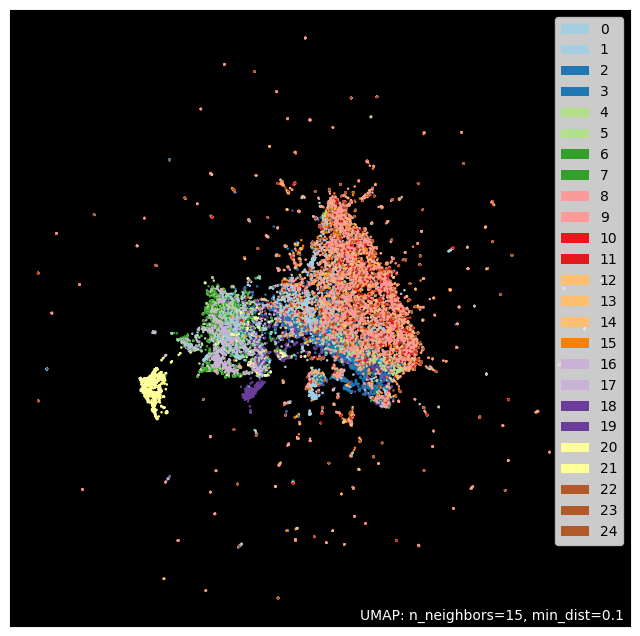

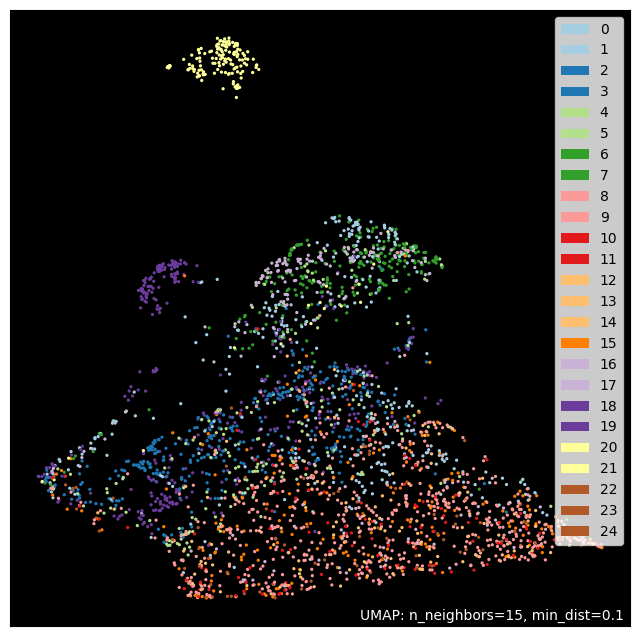

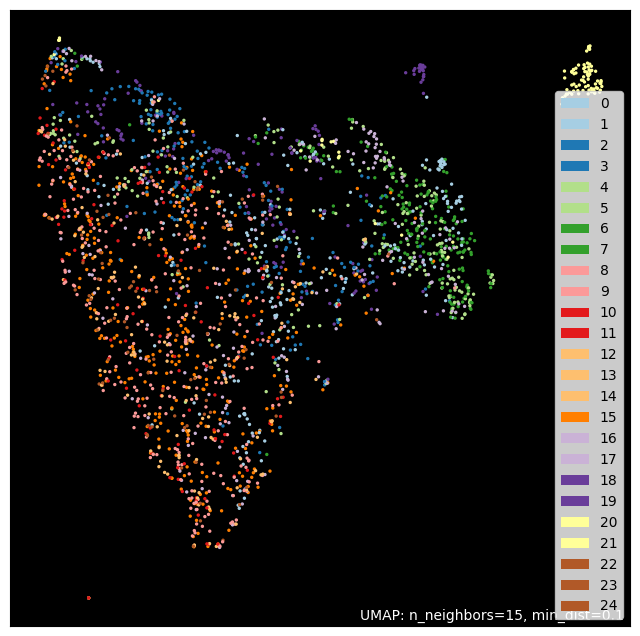

In [5]:
print ("Creating Embeddings...")   

train_embeddings = ESM2.esm2embedding(train, device, layer_index=33, pt_batch_size=1, folder_path=dir_pre_generated_embeddings+'Meltome/train/', correspondence_idx_df_file=idxdf_idxfile_train) 
test_embeddings = ESM2.esm2embedding(test, device, layer_index=33, pt_batch_size=1, folder_path=dir_pre_generated_embeddings+'Meltome/test/', correspondence_idx_df_file=idxdf_idxfile_test) 
val_embeddings = ESM2.esm2embedding(val, device, layer_index=33, pt_batch_size=1, folder_path=dir_pre_generated_embeddings+'Meltome/val/', correspondence_idx_df_file=idxdf_idxfile_val)



IF_embeddings_train = exp.IF_repr(train, folder_path='../prepro_embeddings/PiFold_if1_embeddings/Meltome_train', correspondence_idx_df_file=idxdf_idxfile_train)
IF_embeddings_test = exp.IF_repr(test, folder_path='../prepro_embeddings/PiFold_if1_embeddings/Meltome_test', correspondence_idx_df_file=idxdf_idxfile_test)
IF_embeddings_val = exp.IF_repr(val, folder_path='../prepro_embeddings/PiFold_if1_embeddings/Meltome_val', correspondence_idx_df_file=idxdf_idxfile_val)


print('starting UMAP mapping ....')
import umap, umap.plot
from pprint import pprint
import ipdb; ipdb.set_trace()


ESM2train_UMAPproj = umap.UMAP(n_components=2).fit(train_embeddings.numpy())
ESM2trainlabels =  pd.Categorical(train.organism).codes

ESM2test_UMAPproj = umap.UMAP(n_components=2).fit(test_embeddings.numpy())
ESM2testlabels =  pd.Categorical(test.organism).codes

ESM2val_UMAPproj = umap.UMAP(n_components=2).fit(val_embeddings.numpy())
ESM2vallabels =  pd.Categorical(val.organism).codes

import ipdb; ipdb.set_trace()


print("ESM2 EMBEDDINGS UMAP PLOTS:\n\n")
pprint(f' ESM2 categories on training data: \n { pd.Categorical(train.organism).categories.tolist()}')
umap.plot.points(ESM2train_UMAPproj, labels=ESM2trainlabels, color_key_cmap='Paired', background='black' )

pprint(f'\n\n ESM2 categories on test data: \n { pd.Categorical(test.organism).categories.tolist()}')
umap.plot.points(ESM2test_UMAPproj, labels=ESM2testlabels, color_key_cmap='Paired', background='black' )

pprint(f'\n\n ESM2 categories on validation data: \n { pd.Categorical(val.organism).categories.tolist()}')
umap.plot.points(ESM2val_UMAPproj, labels=ESM2vallabels, color_key_cmap='Paired', background='black' )


"""
print("PiFold EMBEDDINGS UMAP PLOTS:\n\n")
print(f' PiFold categories on training data: \n { pd.Categorical(train.organism)}')
umap.plot.points(ESM2train_UMAPproj, labels=ESM2trainlabels, color_key_cmap='Paired', background='black' )

print(f' PiFold categories on test data: \n { pd.Categorical(test.organism)}')
umap.plot.points(ESM2test_UMAPproj, labels=ESM2testlabels, color_key_cmap='Paired', background='black' )

print(f' PiFold categories on validation data: \n { pd.Categorical(val.organism)}')
umap.plot.points(ESM2val_UMAPproj, labels=ESM2vallabels, color_key_cmap='Paired', background='black' )
"""

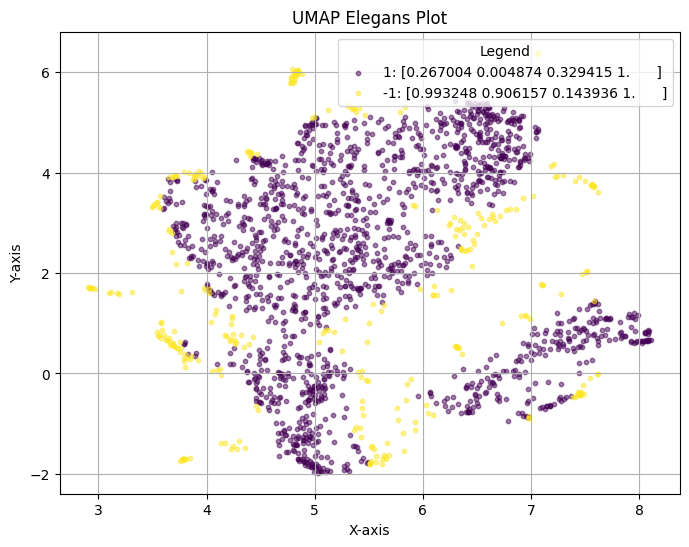

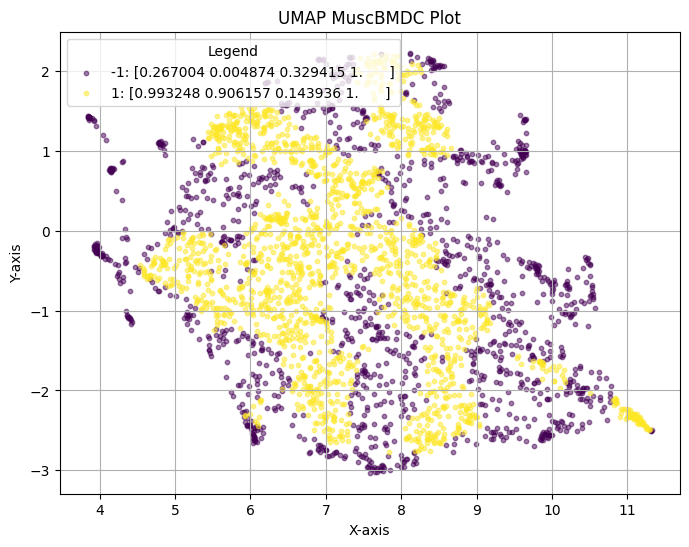

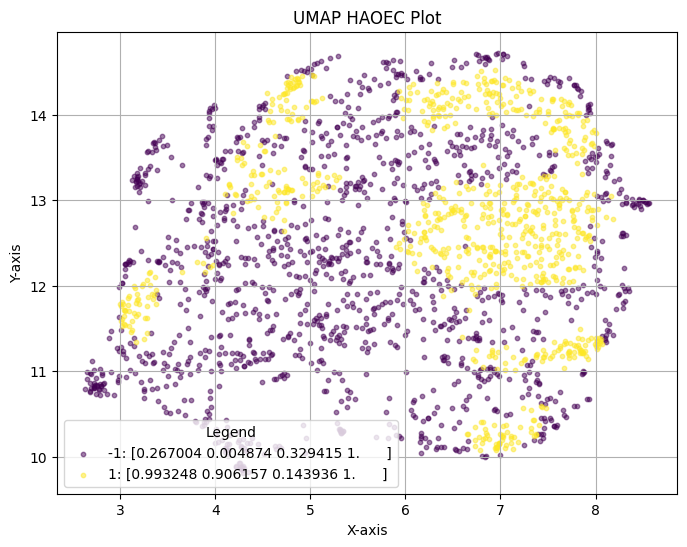

In [21]:
import pandas as pd
import matplotlib.pyplot as plt


path_org1 = '../datasets/clean_up_NVZ_per_species_MeltomeMix/Caenorhabditis_elegans_lysate/temp.clusters.4.tsv'
path_org2 = '../datasets/clean_up_NVZ_per_species_MeltomeMix/Mus_musculus_BMDC_lysate/temp.clusters.4.tsv'
path_org3 = '../datasets/clean_up_NVZ_per_species_MeltomeMix/HAOEC/temp.clusters.6.tsv'
#path_global = '../datasets/clean_up_NVZ_per_species_MeltomeMix/AllMeltomeMix_clean_per_species_30_clusters.tsv'

def assign_colors_to_strings(string_list, colormap_name='viridis'):
    # Create a colormap with as many colors as there are unique strings
    unique_strings = list(set(string_list))
    num_unique_strings = len(unique_strings)
    colormap = plt.get_cmap(colormap_name, num_unique_strings)
    
    # Create a dictionary that maps each unique string to a color
    color_mapping = {string: colormap(i) for i, string in enumerate(unique_strings)}
    
    # Create a list of colors for each string in the original list
    colors = [color_mapping[string] for string in string_list]
    
    return colors

def map_values(value):
    if value!=-1:
        return 1
    else:
        return -1

def create_scatterplot(dataframe, x_column, y_column, class_label, title="UMAP Plot", x_label="X-axis", y_label="Y-axis"):
    # Create a scatter plot
    dataframe[class_label]=dataframe[class_label].apply(map_values)
    plt.figure(figsize=(8, 6))
    categories=dataframe[class_label].unique().tolist()
    colors = plt.cm.viridis(np.linspace(0, 1, len(categories)))  # Adjust the colormap as needed
    

     
    #color_list = assign_colors_to_strings( categories)
    #colors = dict( zip(categories, color_list) )
    
    #plt.scatter(dataframe[x_column], dataframe[y_column], s=10, alpha=0.5,  label=dataframe[class_label], color=colors)
    for i, class_l in enumerate(categories):
        class_data = dataframe[dataframe[class_label] == class_l]
        plt.scatter(class_data[x_column], class_data[y_column], s=10, alpha=0.5, label=class_l, color=colors[i])

    
    # Set axis labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    
     # Add a legend with labels specifying which class belongs to each color
    legend_labels = [f"{class_l}: {class_color}" for class_l, class_color in zip(categories, colors)]
    plt.legend(legend_labels, title="Legend")
    #plt.legend()
    # Show the plot
    plt.grid(True)
    plt.show()

# Example usage:
# Create a sample DataFrame (you can replace this with your own DataFrame)

df_org1 = pd.read_csv(path_org1, sep='\t')
df_org2 = pd.read_csv(path_org2, sep='\t')
df_org3 = pd.read_csv(path_org3, sep='\t')


# Call the function to create a scatter plot
create_scatterplot(df_org1, x_column='umap1', y_column='umap2', class_label='cluster', title='UMAP Elegans Plot')
create_scatterplot(df_org2, x_column='umap1', y_column='umap2', class_label='cluster', title='UMAP MuscBMDC Plot')
create_scatterplot(df_org3, x_column='umap1', y_column='umap2', class_label='cluster', title='UMAP HAOEC Plot')



